In [95]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact
import glob
from pprint import pprint
from scipy.constants import elementary_charge as qe, electron_mass as me

%matplotlib inline

In [96]:
all_files = glob.glob(r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files\*.dsp")
# pprint([os.path.split(all_files[i])[1] for i in range(len(all_files))])

# Sensitivity as a function of helium height $h$ and a single $x_{sep}$

101it [00:01, 69.49it/s]
101it [00:01, 66.60it/s]
101it [00:01, 76.08it/s]
101it [00:01, 75.45it/s]
101it [00:01, 69.63it/s]
101it [00:01, 88.86it/s]
101it [00:01, 88.78it/s]
101it [00:01, 72.63it/s]
101it [00:01, 84.62it/s]
101it [00:01, 84.48it/s]
101it [00:01, 83.22it/s]


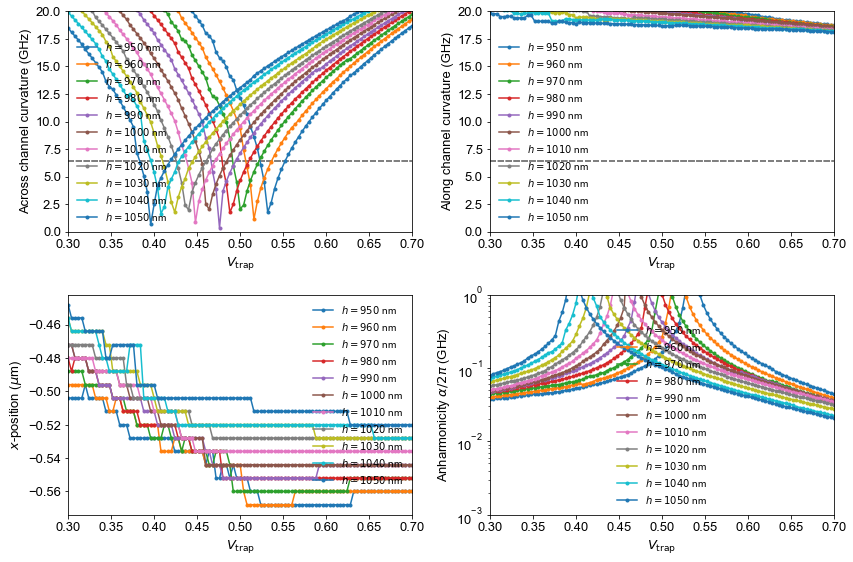

In [97]:
hs = np.arange(950, 1060, 10).tolist() #[980, 990, 1000, 1010, 1020] # nm
fit_potential_minimum=True
Npts = 101

mu = -0.515
xsep = 0.63

def f_mu(mu):
    return -2.80 - 6.83*mu

Vtrap_park = 0.7
Vtrap_stop = 0.3
Vrg_start = -1/2.45*(Vtrap_park - (f_mu(mu)))-xsep
Vrg_stop = -1/2.45*(Vtrap_stop - (f_mu(mu)))-xsep

Vtraps = np.linspace(Vtrap_park, Vtrap_stop, Npts)
Vresguards = np.linspace(Vrg_start, Vrg_stop, Npts)
resonator = 1.00
trapguard = 0.00

# Evaluate all files in the range
xeval = np.linspace(-2, 2, 501)
yeval = anneal.construct_symmetric_y(-4, 201)

mother_path = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files"
names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
electron_frequencies = list()

fig = plt.figure(figsize=(12.,8.))
common.configure_axes(13)

for h in hs:
    datafiles = [r"Resonator_%dnm.dsp"%h, r"Trap_%dnm.dsp"%h, "ResonatorGuard_%dnm.dsp"%h, "Trapguard_%dnm.dsp"%h]

    output = list()

    for name, datafile in zip(names, datafiles):
#         plt.figure(figsize=(7.,4.))
#         common.configure_axes(13)
        elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(mother_path, datafile))
        xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
        xcenter = np.mean(bounding_box[0:2])
        ycenter = np.mean(bounding_box[2:4])
        xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                             plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False, plot_data=0)

        # Mirror around the y-axis
        ysize, xsize = np.shape(Uinterp)
        Uinterp_symmetric = np.zeros((2 * ysize, xsize))
        Uinterp_symmetric[:ysize, :] = Uinterp
        Uinterp_symmetric[ysize:, :] = Uinterp[::-1, :]

        y_symmetric = np.zeros((2 * ysize, xsize))
        y_symmetric[:ysize, :] = yinterp
        y_symmetric[ysize:, :] = -yinterp[::-1, :]

        x_symmetric = np.zeros((2 * ysize, xsize))
        x_symmetric[:ysize, :] = xinterp
        x_symmetric[ysize:, :] = xinterp

        output.append({'name' : name, 
                       'V' : np.array(Uinterp_symmetric, dtype=np.float64),
                       'x' : np.array(x_symmetric, dtype=np.float64), 
                       'y' : np.array(y_symmetric, dtype=np.float64)})

    efreqs_x = np.zeros(len(Vtraps))
    efreqs_y = np.zeros(len(Vtraps))
    xposition = np.zeros(len(Vtraps))
    barrier_height = np.zeros(len(Vtraps))
    barrier_height_minus_trap = np.zeros(len(Vtraps))
    barrier_minus_mu = np.zeros(len(Vtraps))
    trap_level = np.zeros(len(Vtraps))
    quartic_term = np.zeros(len(Vtraps))
    quadratic_term = np.zeros(len(Vtraps))

    x = output[0]['x']
    y = output[0]['y']

    for n, resonatorguard, trap in tqdm(zip(np.arange(Npts), Vresguards, Vtraps)):
        coefficients = np.array([resonator, trap, resonatorguard, trapguard])

        for k, coeff in enumerate(coefficients):
            if k == 0: 
                combined_potential = coeff * output[k]['V']
            else:
                combined_potential += coeff * output[k]['V']    

        if fit_potential_minimum:
            trap_xmin, trap_xmax = (-1.5, 1.0)
            trap_ymin, trap_ymax = (-3.0, 3.0)
            trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
            trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)

            yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                                  ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
            yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
        else: 
            yidx = np.array([common.find_nearest(y[:,0], 0.0)])
            xidx = common.find_nearest(x[0,:], fit_x)

        f0s = list()
        quartic_terms_y, quartic_terms_x  = list(), list()
        quadratic_terms_y, quadratic_terms_x = list(), list()
        # Average f0 one index around the fit_x or potential minimum.
        for X in np.arange(xidx-1, xidx+1 + 1, 1):
            # Determine the electron motional frequency in the y-direction (across-channel)
            Vdata = combined_potential[:,X]
            xdata = y[:,X]
            center = y[yidx, X]

    #             fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
    #             f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    #             f0s.append(f0)

            # V = a0 + a1 x^2 + a2 x^4
            fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1, 2], mode='even', 
                                     domain=(-0.25, +0.25), verbose=False)
            a1, a2 = fr[1], fr[2]

            quartic_terms_y.append(a2)
            quadratic_terms_y.append(a1)

            # Then determine the electron motional frequency in the x-direction (along channel)
            # There is a double well, calculate the minimum according to the fit (take the positive solution)
            xdata = x[yidx, :]
            Vdata = combined_potential[yidx, :]
            center = x[yidx, X]

            # V = a0 + a1 (x - a2)^2
            try:
                fr, ferr = kfit.fit_parabola(xdata, Vdata, fitparams=[0, 1, center], verbose=False, 
                                             domain=(center-0.25, center+0.25))
                a1, a2 = fr[1], fr[2]
            except:
                a1, a2 = np.nan, np.nan

            quadratic_terms_x.append(a1)

        if np.mean(quartic_terms_y) < 0 and np.mean(quadratic_terms_y) > 0:
            # If there's a double well
            efreqs_y[n] = 1 / (2 * np.pi) * np.sqrt(-qe * -4 * np.mean(quadratic_terms_y) * 1E12 / me) 
            efreqs_x[n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me) 
        else:
            efreqs_y[n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_y) * 1E12 / me)
            efreqs_x[n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me)

        res_barrier = (1.0, 2.0)
        res_barrier_min_idx = common.find_nearest(x[0,:], res_barrier[0])
        res_barrier_max_idx = common.find_nearest(x[0,:], res_barrier[1])
        trap_level_idx = common.find_nearest(x[0,:], -5.0)

        trap_barrier = (-2.5, -1.0)
        trap_barrier_min_idx = common.find_nearest(x[0,:], trap_barrier[0])
        trap_barrier_max_idx = common.find_nearest(x[0,:], trap_barrier[1])

        quartic_term[n] = np.mean(quartic_terms_y)
        quadratic_term[n] = np.mean(quadratic_terms_y)

        xposition[n] = x[0, xidx]
        barrier_height_minus_trap[n] = np.min([np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx], 
                                                np.max(-combined_potential[int(len(y[:,0])/2), trap_barrier_min_idx:trap_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx]])
        barrier_minus_mu[n] = np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) - mu
        trap_level[n] = -combined_potential[int(len(y[:,0])/2), trap_level_idx]
    
    electron_frequencies.append(efreqs_y / 1E9)
    anharm_GHz = -1 / (2 * np.pi * 1E9) * 3 * qe * quartic_term * 1E24 * 1.055E-34 / (me**2 * (2 * np.pi * efreqs_y)**2)

    plt.subplot(221)
    plt.plot(Vtraps, efreqs_y / 1e9, '.-', label=r'$h = %.0f$ nm'%h)
    plt.ylabel("Across channel curvature (GHz)")
    plt.hlines(6.45, np.min(Vtraps), np.max(Vtraps), linestyles='--', color='gray')
    plt.ylim(0, 20)
    
    plt.subplot(222)
    plt.plot(Vtraps, efreqs_x / 1e9, '.-', label=r'$h = %.0f$ nm'%h)
    plt.ylabel("Along channel curvature (GHz)")
    plt.hlines(6.45, np.min(Vtraps), np.max(Vtraps), linestyles='--', color='gray')
    plt.ylim(0, 20)
    
    plt.subplot(223)
    plt.plot(Vtraps, xposition, '.-', label=r'$h = %.0f$ nm'%h)
    plt.ylabel(r"$x$-position ($\mu$m)")
    
    plt.subplot(224)
    plt.plot(Vtraps, anharm_GHz, '.-', label=r'$h = %.0f$ nm'%h)
    plt.ylabel(r"Anharmonicity $\alpha/2\pi$ (GHz)")
    plt.yscale("log")
    plt.ylim(1e-3, 1e0)
    
for k in range(4):
    plt.subplot(2, 2, k+1) 
    plt.legend(loc=0, frameon=False, prop={"size" : 10})    
    plt.xlabel(r"$V_\mathrm{trap}$")
    plt.xlim(np.min(Vtraps), np.max(Vtraps))
   
fig.tight_layout()

In [98]:
electron_frequencies = np.array(electron_frequencies)

Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  ======================  ======================
Parameter            Value                    Std
===========  ======================  ======================
a0             1.8560000037200268     0.01970448363455425
a1           -0.0014036363673563905  1.9694638909291126e-05
===========  ======================  ======================
Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  ======================  =====================
Parameter            Value                    Std
===========  ======================  =====================
a0             1.811636364007501     0.016934812176561537
a1           -0.0013272727276438647  1.692635109815627e-05
===========  ======================  =====================
Effective voltage broadening due to z-displacement:(left) 1.4 mV/nm and (right) 1.3 mV/nm


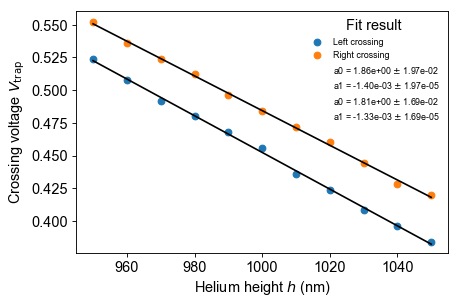

In [99]:
crossings_idcs = list()
for m, h in enumerate(hs):
    below_resonator_idx = common.find_nearest(4, electron_frequencies[m,:])
    
    # Left and right are reversed, because Vtrap is gets smaller
    right_crossing_idx = common.find_nearest(6.45, electron_frequencies[m, :below_resonator_idx])
    left_crossing_idx = below_resonator_idx + common.find_nearest(6.45, electron_frequencies[m, below_resonator_idx:])
    crossings_idcs.append((left_crossing_idx, right_crossing_idx))
    
crossings = np.array(crossings_idcs)
left_crossing_voltages = Vtraps[crossings[:, 0]]
right_crossing_voltages = Vtraps[crossings[:, 1]]
    
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(hs, left_crossing_voltages, 'o', label="Left crossing")
plt.plot(hs, right_crossing_voltages, 'o', label="Right crossing")

fr_left, ferr = kfit.fit_poly(np.array(hs), left_crossing_voltages, fitparams=[0, -1])
plt.plot(hs, kfit.polyfunc(np.array(hs), *fr_left), '-k')

fr_right, ferr = kfit.fit_poly(np.array(hs), right_crossing_voltages, fitparams=[0, -1])
plt.plot(hs, kfit.polyfunc(np.array(hs), *fr_right), '-k')

plt.xlabel("Helium height $h$ (nm)")
plt.ylabel("Crossing voltage $V_\mathrm{trap}$")

print("Effective voltage broadening due to z-displacement:(left) %.1f mV/nm and (right) %.1f mV/nm" % \
      (np.abs(fr_left[1]) * 1E3, np.abs(fr_right[1]) * 1E3))

if 1: 
    common.save_figure(fig, save_path=r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files")

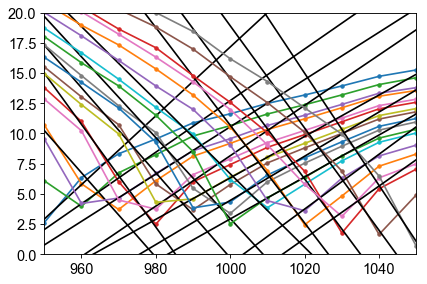

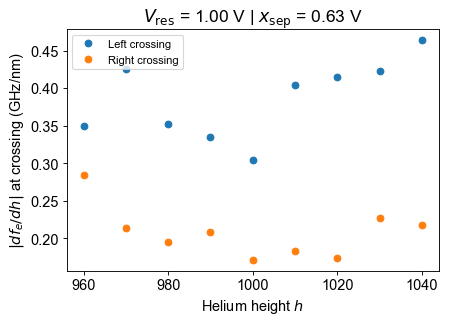

In [100]:
# Frequency at a particular index
ghz_nm_left, ghz_nm_right = list(), list()

plt.figure()

for hoi in hs[1:-1]:
    hidx = common.find_nearest(hoi, np.array(hs))
    right_voi_idx = crossings[hidx, 1]
    left_voi_idx = crossings[hidx, 0]

    plt.plot(hs, electron_frequencies[:, right_voi_idx], '.-', label="Right crossing")
    plt.plot(hs, electron_frequencies[:, left_voi_idx], '.-', label="Left crossing")

    fr_right, ferr = kfit.fit_poly(np.array(hs)[hidx-1:hidx+2], electron_frequencies[hidx-1:hidx+2, right_voi_idx], 
                                   fitparams=[0, 1], verbose=False)
    plt.plot(hs, kfit.polyfunc(np.array(hs), *fr_right), '-k')

    fr_left, ferr = kfit.fit_poly(np.array(hs)[hidx-1:hidx+2], electron_frequencies[hidx-1:hidx+2, left_voi_idx], 
                                  fitparams=[0, 1], verbose=False)
    plt.plot(hs, kfit.polyfunc(np.array(hs), *fr_left), '-k')

    ghz_nm_left.append(fr_left[1])
    ghz_nm_right.append(fr_right[1])
    
plt.ylim(0, 20)
plt.xlim(np.min(hs), np.max(hs))
    
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.title("$V_\mathrm{res}$ = %.2f V | $x_\mathrm{sep}$ = %.2f V" % (resonator, xsep))
plt.plot(hs[1:-1], np.abs(ghz_nm_left), 'o', label="Left crossing")
plt.plot(hs[1:-1], np.abs(ghz_nm_right), 'o', label="Right crossing")
plt.xlabel("Helium height $h$")
plt.ylabel("$|df_e/dh|$ at crossing (GHz/nm)")
plt.legend(loc=0, prop={"size" : 10}, frameon=1)

if 1: 
    common.save_figure(fig, save_path=r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files")

In [70]:
print(np.mean(ghz_nm_left), np.mean(ghz_nm_right))

-0.385832970172 0.208369798613


# For a single helium height $h$, sweep $x_{sep}$ 

This is to answer the question: _What is the dependence of $df_e/dh$ on $x_{sep}$? _ In other words, can we explain why the measured trace, changes in strength and width as we vary $x_{sep}$?

In [102]:
height = 1000 # nm
fit_potential_minimum=True
Npts = 101

mu = -0.515
xseps = np.linspace(0.68, 0.53, 16)

def f_mu(mu):
    return -2.80 - 6.83*mu

Vtrap_park = 0.65
Vtrap_stop = 0.28

resonator = 1.00
trapguard = 0.00

# Evaluate all files in the range
xeval = np.linspace(-2, 2, 501)
yeval = anneal.construct_symmetric_y(-4, 201)

mother_path = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files"
names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
electron_frequencies = list()

fig = plt.figure(figsize=(12.,8.))
common.configure_axes(13)

for nn, h in enumerate([height-10, height, height+10]):
    datafiles = [r"Resonator_%dnm.dsp"%h, r"Trap_%dnm.dsp"%h, "ResonatorGuard_%dnm.dsp"%h, "Trapguard_%dnm.dsp"%h]

    output = list()

    for name, datafile in zip(names, datafiles):
#         plt.figure(figsize=(7.,4.))
#         common.configure_axes(13)
        elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(mother_path, datafile))
        xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
        xcenter = np.mean(bounding_box[0:2])
        ycenter = np.mean(bounding_box[2:4])
        xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                             plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False, plot_data=0)

        # Mirror around the y-axis
        ysize, xsize = np.shape(Uinterp)
        Uinterp_symmetric = np.zeros((2 * ysize, xsize))
        Uinterp_symmetric[:ysize, :] = Uinterp
        Uinterp_symmetric[ysize:, :] = Uinterp[::-1, :]

        y_symmetric = np.zeros((2 * ysize, xsize))
        y_symmetric[:ysize, :] = yinterp
        y_symmetric[ysize:, :] = -yinterp[::-1, :]

        x_symmetric = np.zeros((2 * ysize, xsize))
        x_symmetric[:ysize, :] = xinterp
        x_symmetric[ysize:, :] = xinterp

        output.append({'name' : name, 
                       'V' : np.array(Uinterp_symmetric, dtype=np.float64),
                       'x' : np.array(x_symmetric, dtype=np.float64), 
                       'y' : np.array(y_symmetric, dtype=np.float64)})

    if nn == 0:
        efreqs_x = np.zeros((3, len(xseps), Npts))
        efreqs_y = np.zeros((3, len(xseps), Npts))
        xposition = np.zeros((3, len(xseps), Npts))
        barrier_height = np.zeros((3, len(xseps), Npts))
        barrier_height_minus_trap = np.zeros((3, len(xseps), Npts))
        barrier_minus_mu = np.zeros((3, len(xseps), Npts))
        trap_level = np.zeros((3, len(xseps), Npts))
        quartic_term = np.zeros((3, len(xseps), Npts))
        quadratic_term = np.zeros((3, len(xseps), Npts))
        anharm_GHz = np.zeros((3, len(xseps), Npts))

        
    for jj, xsep in enumerate(xseps):
        # Create the sweeps for different x_seps
        Vrg_start = -1/2.45*(Vtrap_park - (f_mu(mu)))-xsep
        Vrg_stop = -1/2.45*(Vtrap_stop - (f_mu(mu)))-xsep

        Vtraps = np.linspace(Vtrap_park, Vtrap_stop, Npts)
        Vresguards = np.linspace(Vrg_start, Vrg_stop, Npts)
        

        x = output[0]['x']
        y = output[0]['y']

        for n, resonatorguard, trap in tqdm(zip(np.arange(Npts), Vresguards, Vtraps)):
            coefficients = np.array([resonator, trap, resonatorguard, trapguard])

            for k, coeff in enumerate(coefficients):
                if k == 0: 
                    combined_potential = coeff * output[k]['V']
                else:
                    combined_potential += coeff * output[k]['V']    

            if fit_potential_minimum:
                trap_xmin, trap_xmax = (-1.5, 1.0)
                trap_ymin, trap_ymax = (-3.0, 3.0)
                trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
                trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)

                yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                                      ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
                yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
            else: 
                yidx = np.array([common.find_nearest(y[:,0], 0.0)])
                xidx = common.find_nearest(x[0,:], fit_x)

            f0s = list()
            quartic_terms_y, quartic_terms_x  = list(), list()
            quadratic_terms_y, quadratic_terms_x = list(), list()
            # Average f0 one index around the fit_x or potential minimum.
            for X in np.arange(xidx-1, xidx+1 + 1, 1):
                # Determine the electron motional frequency in the y-direction (across-channel)
                Vdata = combined_potential[:,X]
                xdata = y[:,X]
                center = y[yidx, X]

        #             fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
        #             f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
        #             f0s.append(f0)

                # V = a0 + a1 x^2 + a2 x^4
                fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1, 2], mode='even', 
                                         domain=(-0.25, +0.25), verbose=False)
                a1, a2 = fr[1], fr[2]

                quartic_terms_y.append(a2)
                quadratic_terms_y.append(a1)

                # Then determine the electron motional frequency in the x-direction (along channel)
                # There is a double well, calculate the minimum according to the fit (take the positive solution)
                xdata = x[yidx, :]
                Vdata = combined_potential[yidx, :]
                center = x[yidx, X]

                # V = a0 + a1 (x - a2)^2
                try:
                    fr, ferr = kfit.fit_parabola(xdata, Vdata, fitparams=[0, 1, center], verbose=False, 
                                                 domain=(center-0.25, center+0.25))
                    a1, a2 = fr[1], fr[2]
                except:
                    a1, a2 = np.nan, np.nan

                quadratic_terms_x.append(a1)

            if np.mean(quartic_terms_y) < 0 and np.mean(quadratic_terms_y) > 0:
                # If there's a double well
                efreqs_y[nn, jj, n] = 1 / (2 * np.pi) * np.sqrt(-qe * -4 * np.mean(quadratic_terms_y) * 1E12 / me) 
                efreqs_x[nn, jj, n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me) 
            else:
                efreqs_y[nn, jj, n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_y) * 1E12 / me)
                efreqs_x[nn, jj, n] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me)

            res_barrier = (1.0, 2.0)
            res_barrier_min_idx = common.find_nearest(x[0,:], res_barrier[0])
            res_barrier_max_idx = common.find_nearest(x[0,:], res_barrier[1])
            trap_level_idx = common.find_nearest(x[0,:], -5.0)

            trap_barrier = (-2.5, -1.0)
            trap_barrier_min_idx = common.find_nearest(x[0,:], trap_barrier[0])
            trap_barrier_max_idx = common.find_nearest(x[0,:], trap_barrier[1])

            quartic_term[nn, jj, n] = np.mean(quartic_terms_y)
            quadratic_term[nn, jj, n] = np.mean(quadratic_terms_y)

            xposition[nn, jj, n] = x[0, xidx]
            barrier_height_minus_trap[nn, jj, n] = np.min([np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) \
                                             + combined_potential[yidx, xidx], 
                                                    np.max(-combined_potential[int(len(y[:,0])/2), trap_barrier_min_idx:trap_barrier_max_idx]) \
                                             + combined_potential[yidx, xidx]])
            barrier_minus_mu[nn, jj, n] = np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) - mu
            trap_level[nn, jj, n] = -combined_potential[int(len(y[:,0])/2), trap_level_idx]
    
        anharm_GHz[nn, jj, :] = -1 / (2 * np.pi * 1E9) * 3 * qe * quartic_term[nn, jj, :] * 1E24 * 1.055E-34 / (me**2 * (2 * np.pi * efreqs_y[nn, jj, :])**2)

#     plt.subplot(221)
#     plt.plot(Vtraps, efreqs_y / 1e9, '.-', label=r'$h = %.0f$ nm'%h)
#     plt.ylabel("Across channel curvature (GHz)")
#     plt.hlines(6.45, np.min(Vtraps), np.max(Vtraps), linestyles='--', color='gray')
#     plt.ylim(0, 20)
    
#     plt.subplot(222)
#     plt.plot(Vtraps, efreqs_x / 1e9, '.-', label=r'$h = %.0f$ nm'%h)
#     plt.ylabel("Along channel curvature (GHz)")
#     plt.hlines(6.45, np.min(Vtraps), np.max(Vtraps), linestyles='--', color='gray')
#     plt.ylim(0, 20)
    
#     plt.subplot(223)
#     plt.plot(Vtraps, xposition, '.-', label=r'$h = %.0f$ nm'%h)
#     plt.ylabel(r"$x$-position ($\mu$m)")
    
#     plt.subplot(224)
#     plt.plot(Vtraps, anharm_GHz, '.-', label=r'$h = %.0f$ nm'%h)
#     plt.ylabel(r"Anharmonicity $\alpha/2\pi$ (GHz)")
#     plt.yscale("log")
#     plt.ylim(1e-3, 1e0)
    
# for k in range(4):
#     plt.subplot(2, 2, k+1) 
#     plt.legend(loc=0, frameon=False, prop={"size" : 10})    
#     plt.xlabel(r"$V_\mathrm{trap}$")
#     plt.xlim(np.min(Vtraps), np.max(Vtraps))
   
# fig.tight_layout()

101it [00:01, 75.68it/s]
101it [00:01, 74.95it/s]
101it [00:01, 73.59it/s]
101it [00:01, 71.76it/s]
101it [00:01, 64.93it/s]
101it [00:01, 70.55it/s]
101it [00:01, 71.50it/s]
101it [00:01, 74.89it/s]
101it [00:01, 74.51it/s]
101it [00:01, 75.29it/s]
101it [00:01, 70.95it/s]
101it [00:01, 58.98it/s]
101it [00:01, 83.36it/s]
101it [00:01, 85.12it/s]
101it [00:01, 87.86it/s]
101it [00:01, 86.58it/s]
101it [00:01, 75.23it/s]
101it [00:01, 79.74it/s]
101it [00:01, 87.47it/s]
101it [00:01, 81.74it/s]
101it [00:01, 84.98it/s]
101it [00:01, 86.06it/s]
101it [00:01, 83.57it/s]
101it [00:01, 87.40it/s]
101it [00:01, 87.87it/s]
101it [00:01, 84.49it/s]
101it [00:01, 78.08it/s]
101it [00:01, 83.29it/s]
101it [00:01, 85.41it/s]
101it [00:01, 88.50it/s]
101it [00:01, 85.55it/s]
101it [00:01, 84.12it/s]
101it [00:01, 87.78it/s]
101it [00:01, 84.90it/s]
101it [00:01, 83.78it/s]
101it [00:01, 82.41it/s]
101it [00:01, 82.27it/s]
101it [00:01, 85.40it/s]
101it [00:01, 82.75it/s]
101it [00:01, 86.59it/s]


In [103]:
np.shape(efreqs_y)

(3, 16, 101)

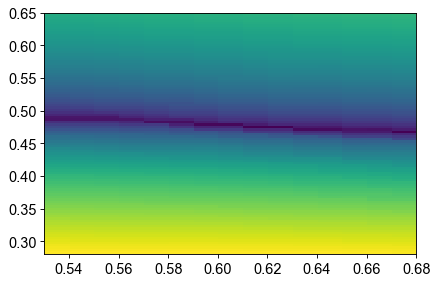

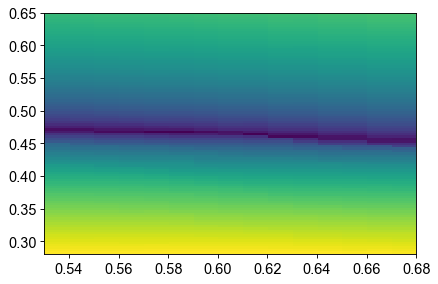

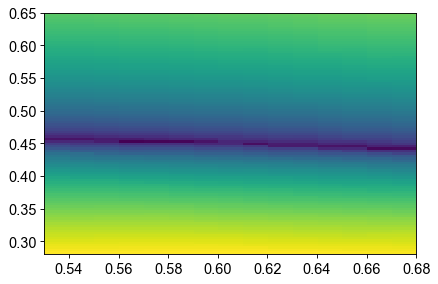

In [104]:
for k in range(3):
    plt.figure()
    plt.pcolormesh(xseps, Vtraps, efreqs_y[k, :, :].T)
    

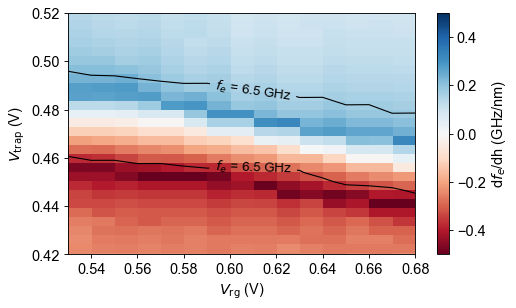

In [113]:
# Calculate df/dh in GHz/nm

fig = plt.figure(figsize=(7.,4.))
plt.pcolormesh(xseps, Vtraps, (efreqs_y[2, :, :].T - efreqs_y[0, :, :].T ) / (20) / 1E9, cmap=plt.cm.RdBu)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"d$f_e$/dh (GHz/nm)")

plt.clim(-0.5, 0.5)
plt.ylim(0.42, 0.52)
plt.xlabel(r"$V_\mathrm{rg}$ (V)")
plt.ylabel(r"$V_\mathrm{trap}$ (V)")

fmt = {}
CS = plt.contour(xseps, Vtraps, efreqs_y[1, :, :].T/1E9, colors='k', levels=[6.5], linewidths=1)
strs = [r"$f_e$ = 6.5 GHz"]
for l, s in zip(CS.levels, strs):
    fmt[l] = s

plt.clabel(CS, colors='black', inline=1, fontsize=12, fmt=fmt)

if 1: 
    common.save_figure(fig, save_path=r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files")

# Helium-resonator coupling with results from Maxwell

In [94]:
f0 = 6.45E9
dh = 10 #nm

esi = 11.45
ehe = 1.056
e0 = 1.0

pvac = 1.84156
psi = 0.5254
phe1 = 1.80011
phe2 = 1.80109

eps_eff_ratio = (esi*psi+e0*pvac+(ehe-e0)*phe1)/(esi*psi+e0*pvac+(ehe-e0)*phe2)

print(eps_eff_ratio)

print(-f0 * (1 - np.sqrt(eps_eff_ratio)) / dh, 'Hz/nm')

0.9999931040124616
-2223.95981522 Hz/nm
